# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.527099,False,0.121136
1,-0.162835,False,-1.242781
2,-0.417895,False,-1.199453
3,1.176550,True,6.703209
4,0.077902,False,0.406159
...,...,...,...
995,0.373784,True,6.079608
996,0.476045,False,0.034666
997,0.583934,False,0.317318
998,2.023003,True,8.767256


<Axes: xlabel='v0'>

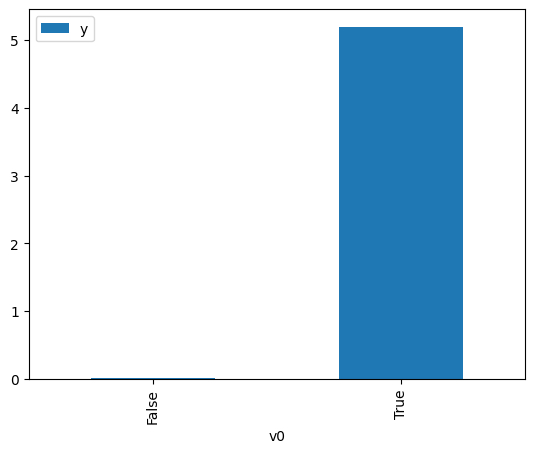

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

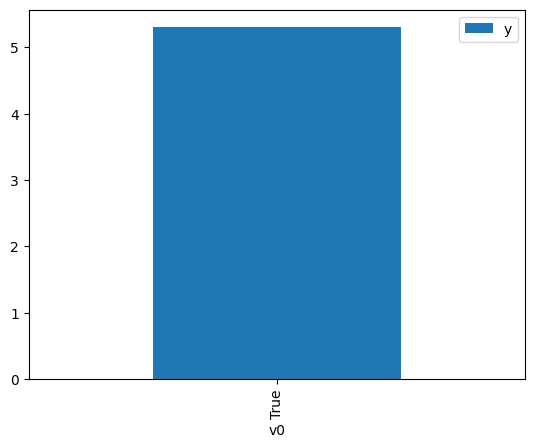

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.691746,False,-0.733120,0.816401,1.224889
1,1.665108,False,2.914564,0.036055,27.735612
2,-1.366071,False,-2.349600,0.945794,1.057313
3,0.691127,False,1.086471,0.212252,4.711383
4,-0.606360,False,-2.510820,0.789022,1.267391
...,...,...,...,...,...
995,-0.529486,False,-1.459416,0.761912,1.312487
996,-0.439226,False,-0.918194,0.727149,1.375234
997,-0.310233,False,0.876422,0.672319,1.487389
998,-1.027715,False,-0.652623,0.897824,1.113804


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.672030,True,6.950790,0.781203,1.280078
1,0.620747,True,5.921371,0.762914,1.310764
2,1.314965,True,8.360049,0.929310,1.076067
3,0.555532,True,5.460180,0.738176,1.354691
4,0.923700,True,7.175198,0.856056,1.168148
...,...,...,...,...,...
995,-0.125208,True,3.512492,0.414939,2.409992
996,-0.516882,True,5.383006,0.242754,4.119399
997,0.905618,True,7.669205,0.851479,1.174427
998,0.062992,True,4.995484,0.509489,1.962751


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.008e+04
Date:                Wed, 15 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:07:40   Log-Likelihood:                         -1388.8
No. Observations:                1000   AIC:                                      2782.
Df Residuals:                     998   BIC:                                      2791.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3531      0.034     39.939      0.000       1.287       1.420
x2             4.9567      0.049    101.319      0.000       4.861       5.053
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.377
Skew:                           0.095   Prob(JB):                        0.185
Kurtosis:                       3.212   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""